<a href="https://colab.research.google.com/github/Kenicki/Kenicki/blob/main/Diabetes_mlops_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tempfile
import os
%matplotlib inline

In [2]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [3]:

import pandas as pd
import seaborn as sns
import missingno as msno
from google.colab import drive

In [7]:

#mount drive to import dataset from google drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# import dataset
df= pd.read_csv('/content/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:

#export dataframe as raw_data
df.to_csv("raw_data.csv",index=False)

In [10]:

#login to wandb
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [11]:
# Send the raw_data.csv to the Wandb storing it as an artifact
!wandb artifact put \
      --name ddiabetes_decision_tree/raw_data.csv \
      --type raw_data \
      --description "The raw data from prima indians" raw_data.csv

wandb: Uploading file raw_data.csv to: "chegenkelvin-kenickilive/ddiabetes_decision_tree/raw_data.csv:latest" (raw_data)
wandb: Currently logged in as: chegenkelvin (chegenkelvin-kenickilive) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /content/wandb/run-20250623_172253-b97ief0i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run treasured-field-2
wandb: ⭐️ View project at https://wandb.ai/chegenkelvin-kenickilive/ddiabetes_decision_tree
wandb: 🚀 View run at https://wandb.ai/chegenkelvin-kenickilive/ddiabetes_decision_tree/runs/b97ief0i
wandb:                                                                                
wandb: 🚀 View run treasured-field-2 at: https://wandb.ai/chegenkelvin-kenickilive/ddiabetes_decision_tree/runs/b97ief0i
wandb: ⭐️ View project at: https://wandb.ai/chegenkelvin-kenickilive/ddiabetes_decision_tree
wandb: Synced 5 W&B file(s), 0 med

In [12]:

# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project="diabetes_decision_tree", save_code=True)

wandb: Currently logged in as: chegenkelvin (chegenkelvin-kenickilive) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact("ddiabetes_decision_tree/raw_data.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

In [14]:

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [15]:
# prompt: df.info()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [16]:

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [17]:

# There are duplicated rows
df.duplicated().sum()

np.int64(0)

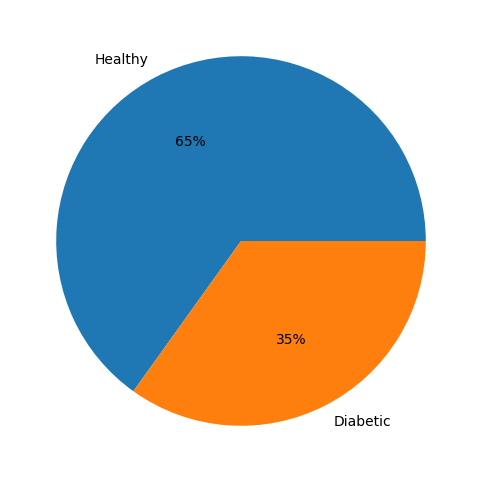

In [18]:
# Is data balanced?
plt.figure(figsize=(6,6))
labels = ['Healthy','Diabetic']
values = [df.Outcome.value_counts()[0], df.Outcome.value_counts()[1]]
plt.pie(values, labels=labels,autopct = '%0.0f%%')
plt.show()

<Axes: >

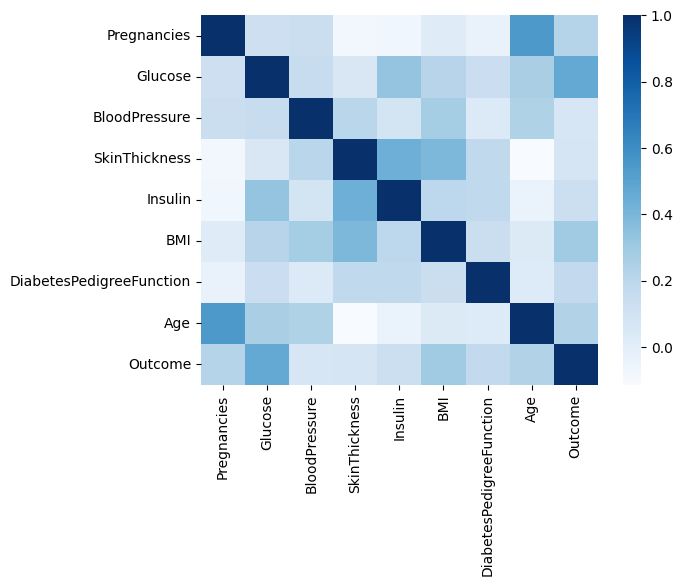

In [19]:

# Correlation
sns.heatmap(df.corr(),cmap='Blues',annot=False)

<Axes: >

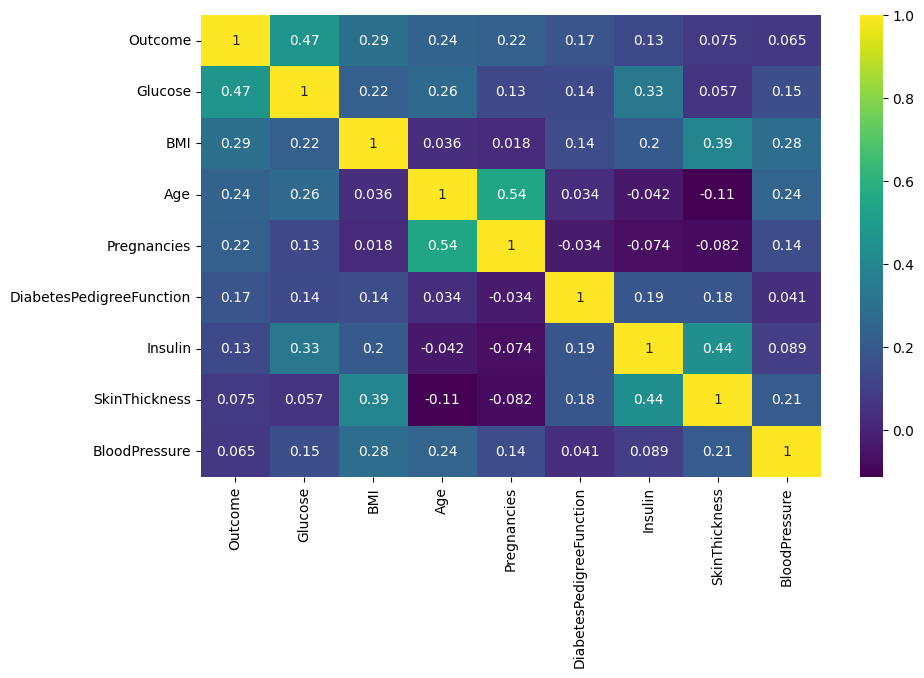

In [20]:
#Outcome correlation matrix
k = 9 #number of variables for heatmap
cols = df.corr().nlargest(k, 'Outcome')['Outcome'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

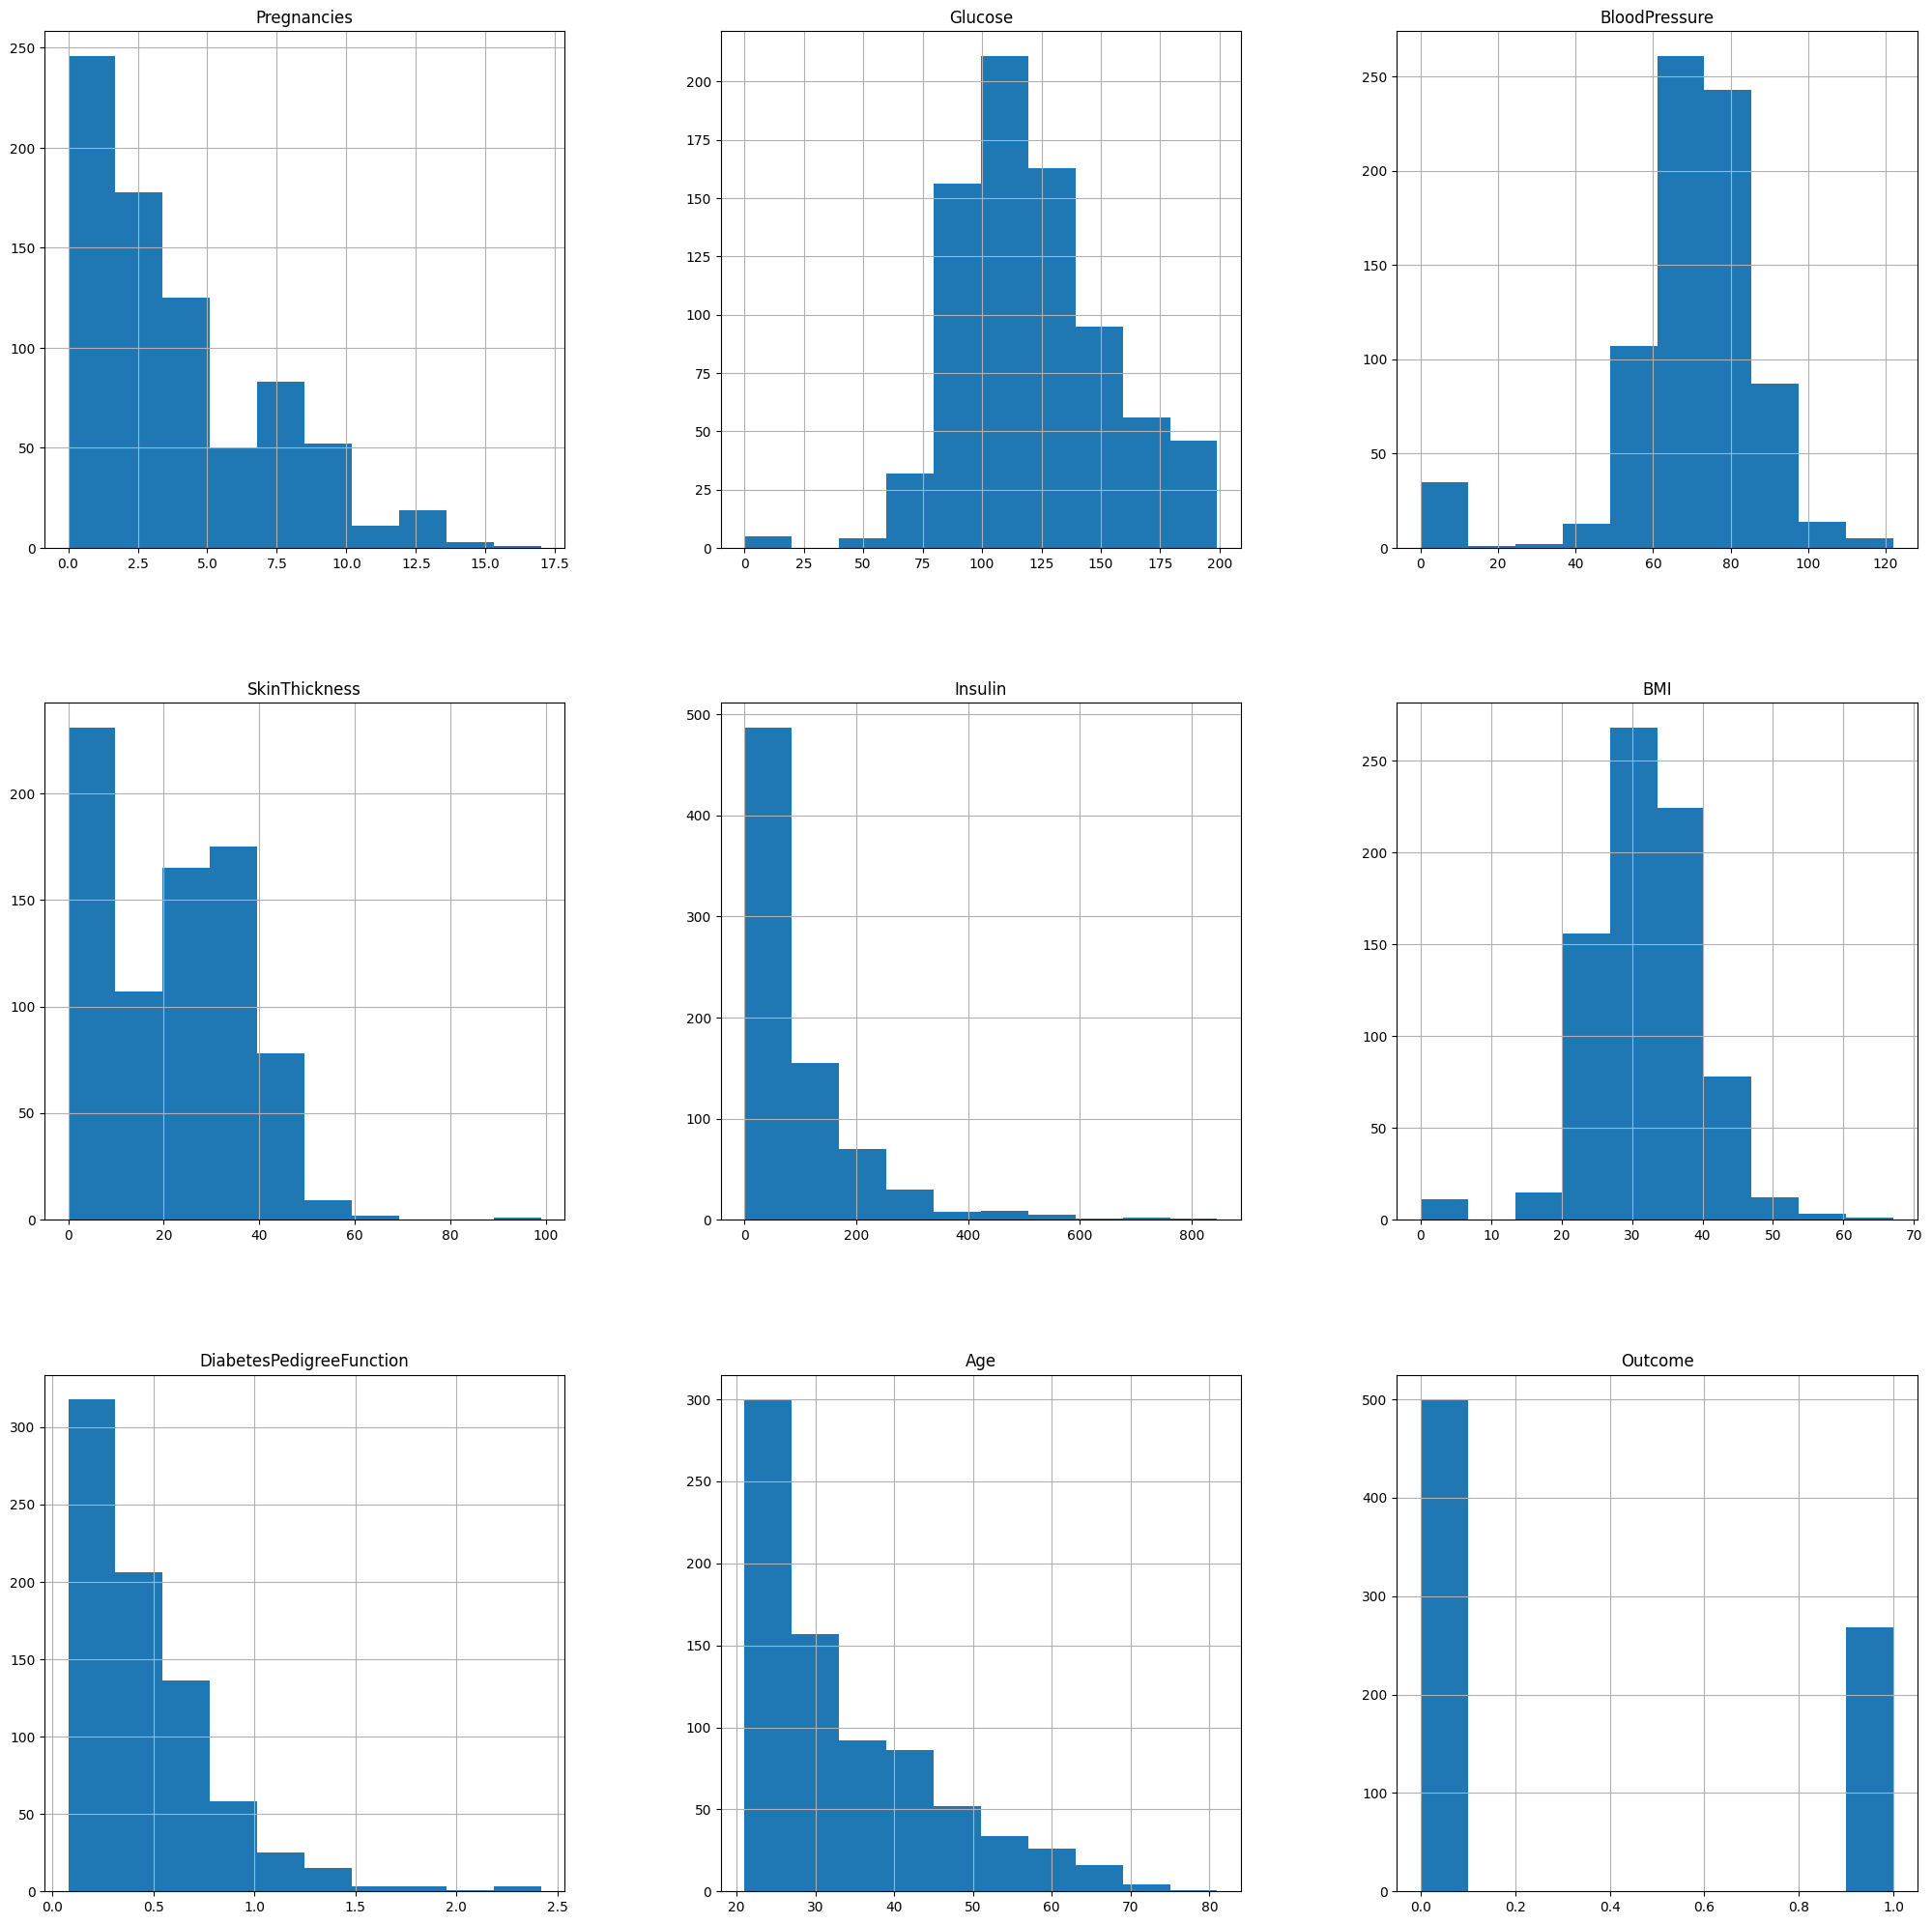

In [21]:
# How the data is distributed.
fig = df.hist(figsize = (25,25))
plt.savefig('featureHist.png',dpi=300)
run.log(
        {
            "FeaturesHist": wandb.Image("featureHist.png")
        }
        )

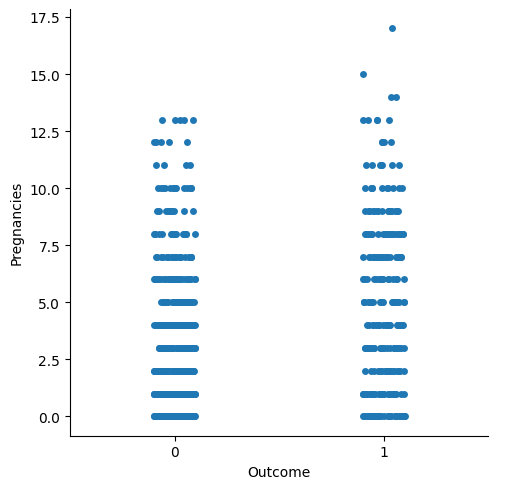

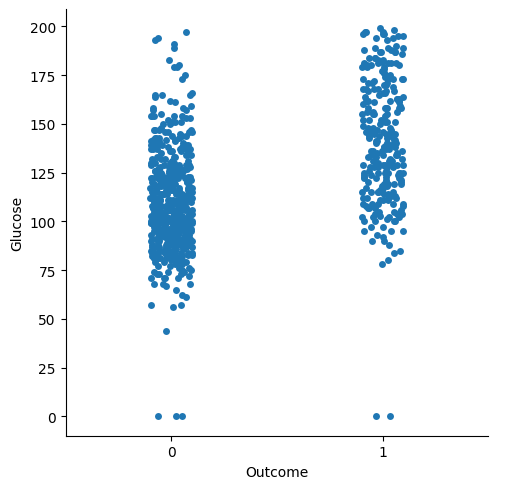

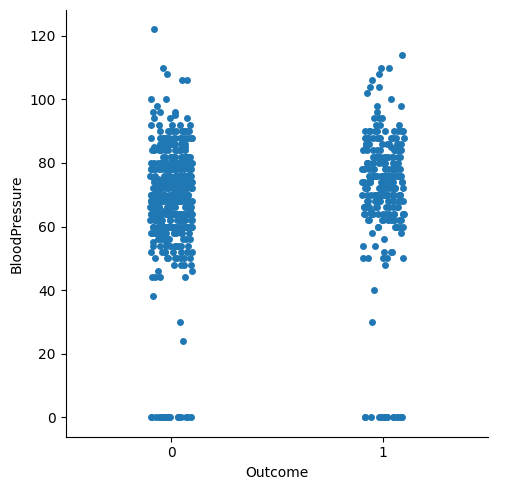

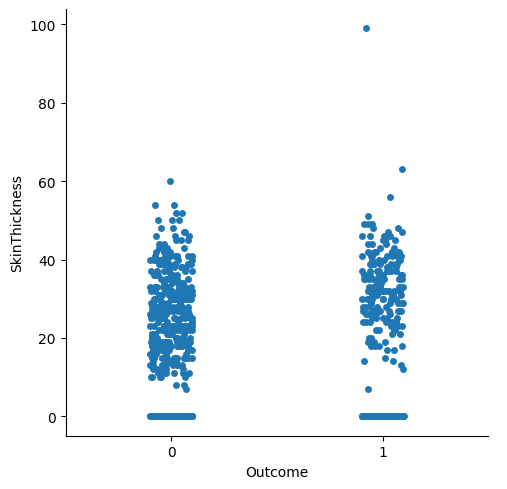

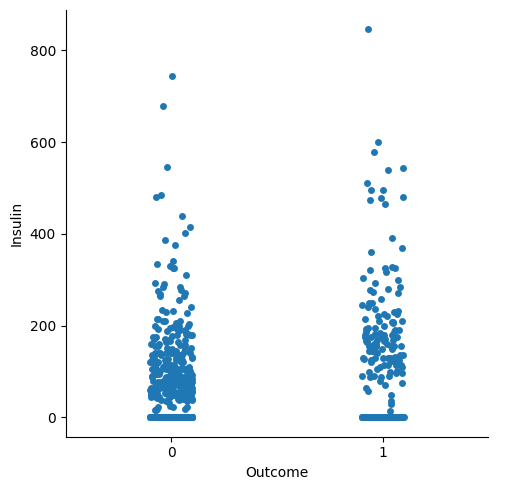

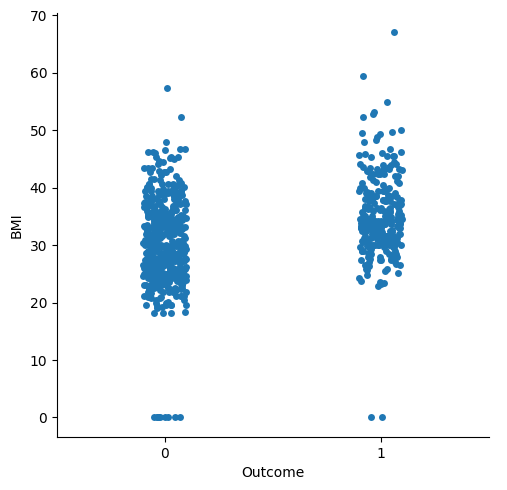

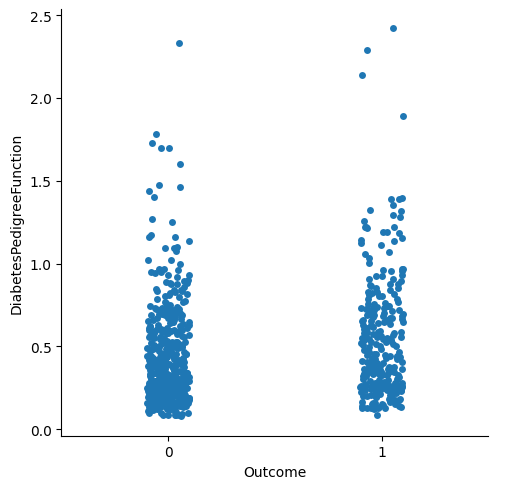

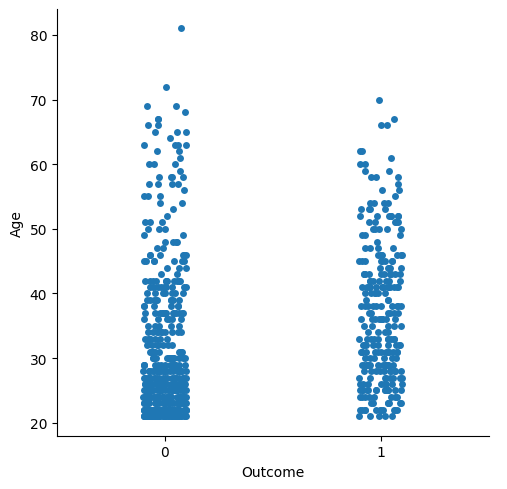

In [22]:
for col in df.columns:
    if col != "Outcome":
        sns.catplot(x="Outcome", y=col, data=df)

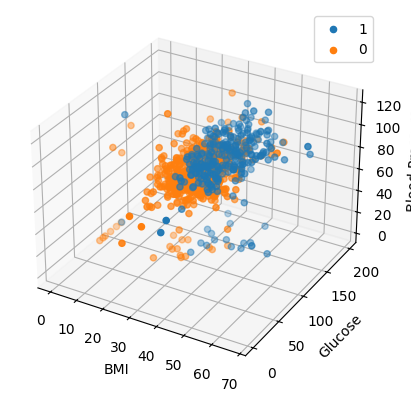

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in df.Outcome.unique():
    ax.scatter(df.BMI[df.Outcome==s],df.Glucose[df.Outcome==s],df.BloodPressure[df.Outcome==s],label=s)
ax.legend()
ax.set_xlabel('BMI')
ax.set_ylabel('Glucose')
ax.set_zlabel('Blood Pressure')

ax.figure.savefig('BMIxGlucosexBloodPressure.png', dpi=300)

In [24]:

%%file test_data.py
import pytest
import wandb
import pandas as pd

Overwriting test_data.py


In [25]:
# This is global so all tests are collected under the same run
run = wandb.init(project="diabetes_decision_tree", job_type="data_checks")


In [30]:

def data():

    local_path = run.use_artifact("diabetes_decision_tree/preprocessed_data.csv:latest").file()
    df = pd.read_csv(local_path)

    return df

def test_data_length(data):
    """
    We test that we have enough data to continue
    """
    assert len(data) > 500


def test_number_of_columns(data):
    """
    We test that we have enough data to continue
    """
    assert data.shape[1] == 9

def test_column_presence_and_type(data):

    required_columns = {
        "Pregnancies": pd.api.types.is_int64_dtype,
        "Glucose": pd.api.types.is_int64_dtype,
        "BloodPressure": pd.api.types.is_int64_dtype,
        "SkinThickness": pd.api.types.is_int64_dtype,
        "Insulin": pd.api.types.is_int64_dtype,
        "BMI": pd.api.types.is_float_dtype,
        "DiabetesPedigreeFunction": pd.api.types.is_float_dtype,
        "Age": pd.api.types.is_int64_dtype,
        "Outcome": pd.api.types.is_int64_dtype
    }

    # Check column presence
    assert set(data.columns.values).issuperset(set(required_columns.keys()))

    for col_name, format_verification_funct in required_columns.items():

        assert format_verification_funct(data[col_name]), f"Column {col_name} failed test {format_verification_funct}"


def test_class_names(data):

    # Check that only the known classes are present
    known_classes = [0,1]

    assert data["Outcome"].isin(known_classes).all()


def test_column_ranges(data):

    ranges = {
        "Age": (18, 90)
    }

    for col_name, (minimum, maximum) in ranges.items():

        assert data[col_name].dropna().between(minimum, maximum).all(), (
            f"Column {col_name} failed the test. Should be between {minimum} and {maximum}, "
            f"instead min={data[col_name].min()} and max={data[col_name].max()}"
        )

In [31]:
!pytest . -vv

Test session starts (platform: linux, Python 3.11.13, pytest 8.3.5, pytest-sugar 1.0.0)
cachedir: .pytest_cache
rootdir: /content
plugins: sugar-1.0.0, langsmith-0.3.45, typeguard-4.4.3, anyio-4.9.0
collected 0 items                                                              


Results (2.53s):


In [32]:

import wandb
import pandas as pd
import numpy as np
import tempfile
import logging
import os

In [33]:

input_artifact="diabetes_decision_tree/raw_data.csv:latest"
artifact_name="preprocessed_data.csv"
artifact_type="clean_data"
artifact_description="Data after preprocessing"

In [34]:

# create a new job_type
run = wandb.init(project="diabetes_decision_tree", job_type="process_data")

In [35]:
# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact("ddiabetes_decision_tree/raw_data.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

In [36]:

# Delete duplicated rows
df.drop_duplicates(inplace=True)

# Generate a "clean data file"
df.to_csv(artifact_name,index=False)

In [37]:

#df['New_Glucose_Class'] = pd.cut(x=df['Glucose'], bins=[0,139,200],labels = ["Normal","Prediabetes"])
#df['New_BMI_Range'] = pd.cut(x=df['BMI'], bins=[0,18.5,24.9,29.9,100],labels = ["Underweight","Healty","Overweight","Obese"])
#df['New_BloodPressure'] = pd.cut(x=df['BloodPressure'], bins=[0,79,89,123],labels = ["Normal","HS1","HS2"])
#df['New_SkinThickness'] = df['SkinThickness'].apply(lambda x: 1 if x <= 18.0 else 0)
df['New_BMI_Range'] = np.where(df['BMI'] < 18.5, "Underweight", np.where(df['BMI'] < 24.9, "Healty", np.where(df['BMI'] < 29.9, "Overweight", "Obese")))
df['New_Glucose_Class'] = np.where(df['Glucose'] < 139, "Normal", "Prediabetes")
df['New_BloodPressure'] = np.where(df['BloodPressure'] < 79, "Normal", np.where(df['BloodPressure'] < 89, "HS1", "HS2"))
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_BMI_Range,New_Glucose_Class,New_BloodPressure
0,6,148,72,35,0,33.6,0.627,50,1,Obese,Prediabetes,Normal
1,1,85,66,29,0,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Healty,Prediabetes,Normal
3,1,89,66,23,94,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Obese,Normal,Normal


In [38]:

df.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64
New_BMI_Range,object


In [39]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

In [40]:

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_BMI_Range,New_Glucose_Class,New_BloodPressure
0,6,148,72,35,0,33.6,0.627,50,1,Obese,Prediabetes,Normal
1,1,85,66,29,0,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Healty,Prediabetes,Normal
3,1,89,66,23,94,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Obese,Normal,Normal


In [41]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()
with tempfile.TemporaryDirectory() as tmp_dir:
        temp_path = os.path.join(tmp_dir, artifact_name)
        df.to_csv(temp_path,index=False)

        artifact = wandb.Artifact(name=artifact_name,
                                  type=artifact_type,
                                  description="pre processed data",
        )

        artifact.add_file(temp_path)

        logger.info("Logging artifact")
        run.log_artifact(artifact)

        # This waits for the artifact to be uploaded to W&B. If you
        # do not add this, the temp directory might be removed before
        # W&B had a chance to upload the datasets, and the upload
        # might fail
        artifact.wait()

In [42]:

# Upload the artifact to Wandb
run.log_artifact(artifact)

<Artifact QXJ0aWZhY3Q6MTgzMTg4MDc5Nw==>

In [43]:
# close the run
# waiting a while after run the previous cell before execute this
run.finish()


In [44]:

import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [111]:
# initiate wandb project
run = wandb.init(project="diabetes_decision_tree", job_type="split_data")

# Use the preprocessed_data.csv artifact for splitting
logger.info("Downloading and reading preprocessed data artifact for splitting")
artifact = run.use_artifact("diabetes_decision_tree/preprocessed_data.csv:latest")
artifact_path = artifact.file()
df = pd.read_csv(artifact_path)

# Split firstly in train/test, then we further divide the dataset to train and validation
logger.info("Splitting data into train, validation, and test")
splits = {}

from sklearn.model_selection import train_test_split
df_train_val, splits["test"] = train_test_split(df, test_size=0.3, random_state=41, stratify=df['Outcome'])
splits["train"], splits["val"] = train_test_split(df_train_val, test_size=0.2, random_state=41, stratify=df_train_val['Outcome'])


# Save the artifacts. We use a temporary directory so we do not leave any trace behind
with tempfile.TemporaryDirectory() as tmp_dir:

    for split, df_split in splits.items():

        # Make the artifact name from the name of the split plus the provided root
        artifact_name = f"{split}.csv"

        # Get the path on disk within the temp directory
        temp_path = os.path.join(tmp_dir, artifact_name)

        logger.info(f"Uploading the {split} dataset to {artifact_name}")

        # Save then upload to W&B
        df_split.to_csv(temp_path,index=False)

        artifact = wandb.Artifact(name=artifact_name, type="segregated_data", description=f"{split} split of dataset 'diabetes_decision_tree/preprocessed_data.csv:latest'")
        artifact.add_file(temp_path)

        run.log_artifact(artifact)

        # This waits for the artifact to be uploaded to W&B. If you
        # do not add this, the temp directory might be removed before
        # W&B had a chance to upload the datasets, and the upload
        # might fail
        artifact.wait()

In [46]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()


In [47]:
# initiate the wandb project
run = wandb.init(project="diabetes_decision_tree",job_type="test")

In [48]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact("diabetes_decision_tree/preprocessed_data.csv:latest").file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("Outcome")

In [49]:

# Takes a look at test set
x_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,New_BMI_Range,New_Glucose_Class,New_BloodPressure
0,6,148,72,35,0,33.6,0.627,50,Obese,Prediabetes,Normal
1,1,85,66,29,0,26.6,0.351,31,Overweight,Normal,Normal
2,8,183,64,0,0,23.3,0.672,32,Healty,Prediabetes,Normal
3,1,89,66,23,94,28.1,0.167,21,Overweight,Normal,Normal
4,0,137,40,35,168,43.1,2.288,33,Obese,Normal,Normal


In [50]:
# Take a look at the target variable
y_test.head()

,Outcome
0,1
1,0
2,1
3,0
4,1


In [61]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [62]:

import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [112]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]


# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # chage values = 0 from some columns
        i = 0
        for col in df.keys():
            if col != 'Pregnancies':
                a = df[col]
                a = a[a != 0]
                a_mean = round(a.median())
                print(col,a_mean)
                df[col].replace(0,a_mean,inplace=True)
                a_mean = 0

        # update columns name


        self.colnames = df.columns.tolist()
        aaa = df.copy()
        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        #df = pd.DataFrame(df, columns=self.colnames)

        return df

# transform float features
class FloatTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # chage values = 0 from some columns
        for col in df.keys():
            a = df[col]
            a = a[a != 0]
            a_mean = round(a.median(),1)
            df[col].replace(0,a_mean,inplace=True)

        # update columns name
        self.colnames = df.columns.tolist()
        aaa = df.copy()
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [84]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "diabetes_decision_tree/test.csv:latest"

# name of the model artifact
artifact_model_name = "diabetes_decision_tree/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "diabetes_decision_tree/target_encoder:latest"


In [85]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [86]:

# initiate the wandb project
run = wandb.init(project="diabetes_decision_tree",job_type="test")

In [68]:

# Takes a look at test set
x_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,137,68,14,148,24.8,0.143,21
1,2,99,70,16,44,20.4,0.235,27
2,9,171,110,24,240,45.4,0.721,54
3,7,105,0,0,0,0.0,0.305,24
4,5,126,78,27,22,29.6,0.439,40


In [69]:
# Take a look at the target variable
y_test.head()

,Outcome
0,0
1,0
2,1
3,0
4,0


In [70]:

# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)


In [75]:

# Takes a look at test set
x_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,137,68,14,148,24.8,0.143,21
1,2,99,70,16,44,20.4,0.235,27
2,9,171,110,24,240,45.4,0.721,54
3,7,105,0,0,0,0.0,0.305,24
4,5,126,78,27,22,29.6,0.439,40


In [76]:

# Take a look at the target variable
y_test.head()

,Outcome
0,0
1,0
2,1
3,0
4,0


In [87]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [88]:

# global variables

# ratio used to split train and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "Outcome"

# name of the input artifact
artifact_input_name = "diabetes_decision_tree/train.csv:latest"

# type of the artifact
artifact_type = "Train"


In [89]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="diabetes_decision_tree",job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

In [90]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

In [91]:

logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("int64").copy()
x = x.join(x_train.select_dtypes("float64").copy())

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

In [92]:

logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

In [93]:

# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

In [94]:
y_train.head(10)

,Outcome
376,0
229,0
60,0
280,0
37,0
34,0
211,0
411,0
9,0
194,1


In [95]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

In [96]:

y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [97]:

y_val

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0])

In [98]:
x_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
376,2,112,66,22,0,25.0,0.307,24
229,6,123,72,45,230,33.6,0.733,34
60,0,104,76,0,0,18.4,0.582,27
280,7,142,60,33,190,28.8,0.687,61
37,4,114,64,0,0,28.9,0.126,24


In [99]:

x_val.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
231,6,154,74,32,193,29.3,0.839,39
91,0,137,40,35,168,43.1,2.288,33
215,1,167,74,17,144,23.4,0.447,33
164,4,146,85,27,100,28.9,0.189,27
30,12,121,78,17,0,26.5,0.259,62


In [103]:
x_train.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64


In [104]:
# Show the shape of x train before transformation
x_train.shape

(275, 8)

In [105]:

# Lets review what are categorical columns
x_train.select_dtypes("object").columns.to_list()

[]

In [106]:
x_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
376,2,112,66,22,0,25.0,0.307,24
229,6,123,72,45,230,33.6,0.733,34
60,0,104,76,0,0,18.4,0.582,27
280,7,142,60,33,190,28.8,0.687,61
37,4,114,64,0,0,28.9,0.126,24


In [107]:
x_val.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
231,6,154,74,32,193,29.3,0.839,39
91,0,137,40,35,168,43.1,2.288,33
215,1,167,74,17,144,23.4,0.447,33
164,4,146,85,27,100,28.9,0.189,27
30,12,121,78,17,0,26.5,0.259,62


In [115]:
# close the current run before to execute the next section
run.finish()

In [116]:
# global variables

# ratio used to split train and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "Outcome"

# name of the input artifact
artifact_input_name = "diabetes_decision_tree/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [117]:

# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="diabetes_decision_tree",job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

In [118]:

logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

In [119]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1


In [120]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))


In [121]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

In [122]:
y_train.head(10)

,Outcome
376,0
229,0
60,0
280,0
37,0
34,0
211,0
411,0
9,0
194,1


In [123]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

In [124]:

logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

In [125]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [126]:

y_val

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0])

In [127]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [128]:

x_val.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
New_BMI_Range,object
New_Glucose_Class,object


In [129]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(column, errors="raise")


,New_BMI_Range,New_Glucose_Class,New_BloodPressure
376,Overweight,Normal,Normal
229,Obese,Normal,Normal
60,Underweight,Normal,Normal
280,Overweight,Prediabetes,Normal
37,Overweight,Normal,Normal


In [130]:

# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,Age
376,2,112,66,22,0,24
229,6,123,72,45,230,34
60,0,104,76,0,0,27
280,7,142,60,33,190,61
37,4,114,64,0,0,24


In [131]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,BMI,DiabetesPedigreeFunction
376,25.0,0.307
229,33.6,0.733
60,18.4,0.582
280,28.8,0.687
37,28.9,0.126


In [132]:

x_val

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,New_BMI_Range,New_Glucose_Class,New_BloodPressure
231,6,154,74,32,193,29.3,0.839,39,Overweight,Prediabetes,Normal
91,0,137,40,35,168,43.1,2.288,33,Obese,Normal,Normal
215,1,167,74,17,144,23.4,0.447,33,Healty,Prediabetes,Normal
164,4,146,85,27,100,28.9,0.189,27,Overweight,Prediabetes,HS1
30,12,121,78,17,0,26.5,0.259,62,Overweight,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...
210,10,75,82,0,0,33.3,0.263,38,Obese,Normal,HS1
297,3,174,58,22,194,32.9,0.593,36,Obese,Prediabetes,Normal
201,1,87,78,27,32,34.6,0.101,22,Obese,Normal,Normal
154,0,84,82,31,125,38.2,0.233,23,Obese,Normal,HS1


In [133]:
# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames
        print(self.colnames)

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())



        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
        # update column names
          self.colnames = df.columns

        return df

In [134]:

# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()


,New_BMI_Range,New_Glucose_Class,New_BloodPressure
376,Overweight,Normal,Normal
229,Obese,Normal,Normal
60,Underweight,Normal,Normal
280,Overweight,Prediabetes,Normal
37,Overweight,Normal,Normal


In [135]:

# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

['New_BMI_Range', 'New_Glucose_Class', 'New_BloodPressure']


,New_BMI_Range,New_Glucose_Class,New_BloodPressure
376,Overweight,Normal,Normal
229,Obese,Normal,Normal
60,Underweight,Normal,Normal
280,Overweight,Prediabetes,Normal
37,Overweight,Normal,Normal


In [136]:

# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

,0
New_BMI_Range,4
New_Glucose_Class,2
New_BloodPressure,3


In [137]:

# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

,0
New_BMI_Range,4
New_Glucose_Class,2
New_BloodPressure,3


In [138]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # chage values = 0 from some columns
        i = 0
        for col in df.keys():
            if col != 'Pregnancies':
                a = df[col]
                a = a[a != 0]
                a_mean = round(a.median())
                print(col,a_mean)
                df[col].replace(0,a_mean,inplace=True)
                a_mean = 0

        # update columns name


        self.colnames = df.columns.tolist()
        aaa = df.copy()
        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        #df = pd.DataFrame(df, columns=self.colnames)

        return df

In [139]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,Age
376,2,112,66,22,0,24
229,6,123,72,45,230,34
60,0,104,76,0,0,27
280,7,142,60,33,190,61
37,4,114,64,0,0,24


In [140]:

# for validation purposes
nt = NumericalTransformer(model=2)
df_num = nt.fit_transform(df)
df_num

Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29


array([[  2, 112,  66,  22, 120,  24],
       [  6, 123,  72,  45, 230,  34],
       [  0, 104,  76,  28, 120,  27],
       ...,
       [  2,  83,  65,  28,  66,  24],
       [  2, 122,  52,  43, 158,  28],
       [  3, 125,  58,  28, 120,  24]])

In [141]:
# return columns name
nt.get_feature_names_out()

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']

In [142]:
# transform float features
class FloatTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # chage values = 0 from some columns
        for col in df.keys():
            a = df[col]
            a = a[a != 0]
            a_mean = round(a.median(),1)
            df[col].replace(0,a_mean,inplace=True)

        # update columns name
        self.colnames = df.columns.tolist()
        aaa = df.copy()
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [143]:
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,BMI,DiabetesPedigreeFunction
376,25.0,0.307
229,33.6,0.733
60,18.4,0.582
280,28.8,0.687
37,28.9,0.126


In [144]:
nt = FloatTransformer(model=2)
df_num = nt.fit_transform(df)
df_num

array([[25.   ,  0.307],
       [33.6  ,  0.733],
       [18.4  ,  0.582],
       [28.8  ,  0.687],
       [28.9  ,  0.126],
       [21.8  ,  0.279],
       [34.   ,  0.391],
       [25.8  ,  0.207],
       [35.3  ,  0.705],
       [34.4  ,  0.402],
       [35.   ,  0.233],
       [39.4  ,  0.661],
       [34.3  ,  0.303],
       [29.5  ,  0.626],
       [29.3  ,  0.349],
       [31.2  ,  0.258],
       [36.6  ,  0.412],
       [47.9  ,  0.259],
       [42.4  ,  1.076],
       [31.6  ,  0.197],
       [32.7  ,  0.734],
       [39.6  ,  0.93 ],
       [36.3  ,  0.258],
       [34.9  ,  0.725],
       [21.2  ,  0.415],
       [39.4  ,  0.175],
       [42.9  ,  0.516],
       [39.9  ,  0.331],
       [37.6  ,  0.304],
       [32.   ,  0.443],
       [32.5  ,  0.256],
       [39.5  ,  0.293],
       [34.3  ,  1.189],
       [28.4  ,  0.495],
       [30.5  ,  0.345],
       [44.1  ,  0.686],
       [31.6  ,  0.268],
       [32.8  ,  0.18 ],
       [37.7  ,  0.254],
       [30.1  ,  0.892],


In [145]:
# return columns name
nt.get_feature_names_out()

['BMI', 'DiabetesPedigreeFunction']

In [146]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("int64").columns.to_list()

float_features = x_train.select_dtypes("float").columns.to_list()

numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('num_transformer', NumericalTransformer(numerical_model,
                                      colnames=numerical_features)),
                                     ])

# Defining the steps in the float pipeline
float_pipeline = Pipeline(steps=[('flt_selector', FeatureSelector(float_features)),
                                     ('flt_transformer', FloatTransformer(numerical_model,
                                      colnames=float_features)),
                                     ])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[
                                                             ('flt_pipeline', float_pipeline),
                                                             ('num_pipeline', numerical_pipeline)
                                                             ]
                                           )


In [147]:
x_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,New_BMI_Range,New_Glucose_Class,New_BloodPressure
376,2,112,66,22,0,25.0,0.307,24,Overweight,Normal,Normal
229,6,123,72,45,230,33.6,0.733,34,Obese,Normal,Normal
60,0,104,76,0,0,18.4,0.582,27,Underweight,Normal,Normal
280,7,142,60,33,190,28.8,0.687,61,Overweight,Prediabetes,Normal
37,4,114,64,0,0,28.9,0.126,24,Overweight,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...
142,2,105,58,40,94,34.9,0.225,25,Obese,Normal,Normal
69,1,112,72,30,176,34.4,0.528,25,Obese,Normal,Normal
228,2,83,65,28,66,36.8,0.629,24,Obese,Normal,Normal
367,2,122,52,43,158,36.2,0.816,28,Obese,Normal,Normal


In [148]:

# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][1].get_feature_names_out()
# float_names is a list
flt_names = full_pipeline_preprocessing.get_params()["flt_pipeline"][1].get_feature_names_out()



df = pd.DataFrame(new_data,columns = flt_names + num_names)
df.head()

Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29


,BMI,DiabetesPedigreeFunction,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,Age
0,0.469925,0.135398,0.133333,0.397163,0.514286,0.392857,0.272727,0.061224
1,0.631579,0.394050,0.400000,0.475177,0.600000,0.803571,0.522727,0.265306
2,0.345865,0.302368,0.000000,0.340426,0.657143,0.500000,0.272727,0.122449
3,0.541353,0.366120,0.466667,0.609929,0.428571,0.589286,0.431818,0.816327
4,0.543233,0.025501,0.266667,0.411348,0.485714,0.500000,0.272727,0.061224


In [149]:
x_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,New_BMI_Range,New_Glucose_Class,New_BloodPressure
376,2,112,66,22,0,25.0,0.307,24,Overweight,Normal,Normal
229,6,123,72,45,230,33.6,0.733,34,Obese,Normal,Normal
60,0,104,76,0,0,18.4,0.582,27,Underweight,Normal,Normal
280,7,142,60,33,190,28.8,0.687,61,Overweight,Prediabetes,Normal
37,4,114,64,0,0,28.9,0.126,24,Overweight,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...
142,2,105,58,40,94,34.9,0.225,25,Obese,Normal,Normal
69,1,112,72,30,176,34.4,0.528,25,Obese,Normal,Normal
228,2,83,65,28,66,36.8,0.629,24,Obese,Normal,Normal
367,2,122,52,43,158,36.2,0.816,28,Obese,Normal,Normal


In [150]:
# The full pipeline
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier(max_depth=4))
                         ]
                )
# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


In [151]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [152]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29


In [153]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))


              precision    recall  f1-score   support

           0       0.74      0.83      0.78        84
           1       0.59      0.44      0.51        45

    accuracy                           0.70       129
   macro avg       0.66      0.64      0.64       129
weighted avg       0.69      0.70      0.69       129



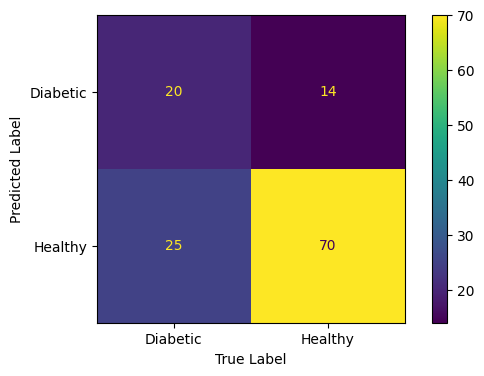

In [169]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=['Diabetic','Healthy']).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [171]:

# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

UsageError: Run (0xipmcls) is finished. The call to `log` will be ignored. Please make sure that you are using an active run.

In [156]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([0.21650967, 0.11274619, 0.10244747, 0.50859475, 0.        ,
       0.        , 0.        , 0.05970191])

In [157]:

# Get categorical column names
flt_names = pipe.named_steps['full_pipeline'].get_params()["flt_pipeline"][1].get_feature_names_out()
flt_names

['BMI', 'DiabetesPedigreeFunction']

In [172]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][1].get_feature_names_out()
num_names

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']

In [179]:

# merge all column names together
all_names = flt_names + num_names
all_names

['BMI',
 'DiabetesPedigreeFunction',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'Age']

In [180]:
# global seed
seed = 41

In [181]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        },
        "max_depth": {
            "values": [4]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="diabetes_decision_tree")

Create sweep with ID: zi4xatm1
Sweep URL: https://wandb.ai/chegenkelvin-kenickilive/diabetes_decision_tree/sweeps/zi4xatm1


In [182]:
def train():
    with wandb.init() as run:

        # The full pipeline
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [183]:

wandb.agent(sweep_id, train, count=8)

wandb: Agent Starting Run: feed3z2v with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 4
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.70543
F1,0.53659
Precision,0.59459
Recall,0.48889


wandb: Agent Starting Run: 3tay94k4 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 4
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.63566
F1,0.41975
Precision,0.47222
Recall,0.37778


wandb: Agent Starting Run: bpdomd2w with config:
wandb: 	criterion: gini
wandb: 	max_depth: 4
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.63566
F1,0.41975
Precision,0.47222
Recall,0.37778


wandb: Agent Starting Run: jk83q33m with config:
wandb: 	criterion: gini
wandb: 	max_depth: 4
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.63566
F1,0.41975
Precision,0.47222
Recall,0.37778


wandb: Agent Starting Run: yvghwe6w with config:
wandb: 	criterion: gini
wandb: 	max_depth: 4
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.63566
F1,0.41975
Precision,0.47222
Recall,0.37778


wandb: Agent Starting Run: ud4gac7s with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 4
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.72868
F1,0.5679
Precision,0.63889
Recall,0.51111


wandb: Agent Starting Run: vt6ha0qb with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 4
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.70543
F1,0.53659
Precision,0.59459
Recall,0.48889


wandb: Agent Starting Run: rxuybkuv with config:
wandb: 	criterion: gini
wandb: 	max_depth: 4
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


Accuracy,0.72093
F1,0.59091
Precision,0.60465
Recall,0.57778


In [184]:
# Note that a new run is yet synced to last sweep run
# Just to check
run = wandb.init()

In [185]:
# The full pipeline
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 0})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__max_depth": 4})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


In [186]:
# float_names is a list
flt_names = full_pipeline_preprocessing.get_params()["flt_pipeline"][1].get_feature_names_out()
flt_names

['BMI', 'DiabetesPedigreeFunction']

In [187]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][1].get_feature_names_out()
num_names

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']

In [189]:
# merge all column names together
all_names = num_names + flt_names
all_names


['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'Age',
 'BMI',
 'DiabetesPedigreeFunction']

In [190]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

Glucose 114
BloodPressure 72
SkinThickness 28
Insulin 120
Age 29
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age

wandb: 
wandb: Plotting BestModel.


 30
Glucose 120
BloodPressure 70
SkinThickness 29
Insulin 129
Age 30


wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [200]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [201]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

['target_encoder']

In [206]:
# Initialize a new run for saving artifacts
run = wandb.init(project="diabetes_decision_tree", job_type="save_artifacts")


# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type='label_encoder', # Corrected artifact type
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

# It's good practice to finish the run when you're done logging
run.finish()